In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from os import path
from linear_opt.lin_metabolism import LinearMetabolicModel

from SALib import ProblemSpec

In [2]:
model_dir = '../models/linear/autotrophy/'
m_fname = path.join(model_dir, 'glucose_auto_molecular_props.csv')
S_fname = path.join(model_dir, 'glucose_auto_stoich_matrix.csv')
lam = LinearMetabolicModel.FromFiles(m_fname, S_fname)
lam.print_model()

Metabolites:
         NC  NOSC  internal                                               note
C_red     1   0.0         1            reduced C, 1 C of intracellular glucose
C_ox      1   4.0         0                      oxidized carbon carrier "CO2"
E_red     1  -4.0         0  reduced donor/acceptor, 2 H2O, NC = 1 for bala...
E_ox      1   0.0         0  oxidized e- donor/acceptor, O2, has fictional ...
ECH      20  -0.1         1  Reduced 2e- carrier, 20*-0.1 => 2 more e- than...
EC       20   0.0         1  Oxidized single e- carrier with 20 carbons. No...
ATP      10   0.0         1                      ATP -- has 10 C atoms really.
ADP      10   0.0         1                                                ADP
biomass   1   0.0         0                   Everything per C, default ZC = 0
Stoichiometries:
                 C_red  C_ox  E_red  E_ox  ECH   EC   ATP   ADP  biomass  \
process                                                                    
oxidation          0.0   0.0

In [3]:
# Do a quick run of the model to make sure it is feasible
lambda_max, opt_p = lam.maximize_lambda(min_phi_o=0.4)
lambda_max

ks @ phis / ms[2]
ks @ phis / ms


/opt/miniconda3/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


0.7854545463622216

In [6]:
# Do a quick run of the model to make sure it is feasible
lambda_max, opt_p = lam.maximize_lambda(min_phi_o=0.4, fixed_ATP=0.001, fixed_NADH=0.001)
lambda_max

ks @ phis / ms[2]
ks @ phis / ms


4.387664867981419e-06

In [5]:
p = lam.max_anabolic_rate_problem(min_phi_o=0.4, max_lambda_hr=0.1)
lambdas = np.arange(0.1, 1.501, 0.01)
results = []

for lam_val in lambdas:
    p.param_dict['max_lambda_hr'].value = lam_val
    res = p.solve()
    d = lam.solution_as_dict(p)
    results.append(d)   

phi_df = pd.DataFrame(results)
phi_df['max_lambda_hr'] = lambdas
phi_df.set_index('lambda_hr', inplace=True)
phi_df.head()

,max_lambda_hr,phi_o,min_phi_o,oxidation_phi,oxidation_flux,reduction_phi,reduction_flux,anabolism_phi,anabolism_flux,cyclic_flow_phi,cyclic_flow_flux,ATP_homeostasis_phi,ATP_homeostasis_flux
lambda_hr,,,,,,,,,,,,,
0.10,0.10,0.447056,0.4,0.055556,0.000111,0.055556,0.000028,0.055556,0.000028,0.201472,0.000101,0.184805,0.000092
0.11,0.11,0.446403,0.4,0.061111,0.000122,0.061111,0.000031,0.061111,0.000031,0.194299,0.000097,0.175965,0.000088
0.12,0.12,0.445141,0.4,0.066667,0.000133,0.066667,0.000033,0.066667,0.000033,0.187429,0.000094,0.167429,0.000084
0.13,0.13,0.443573,0.4,0.072222,0.000144,0.072222,0.000036,0.072222,0.000036,0.180713,0.000090,0.159047,0.000080
0.14,0.14,0.442382,0.4,0.077778,0.000156,0.077778,0.000039,0.077778,0.000039,0.173809,0.000087,0.150476,0.000075


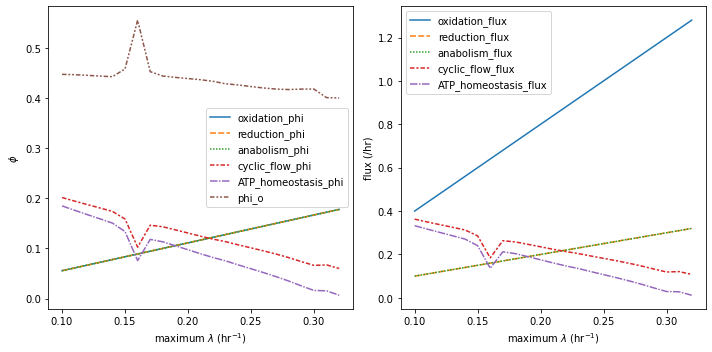

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
mask = (phi_df != 0).all(axis=1)

plt.sca(axs[0])

phi_cols = [c for c in phi_df.columns if c.endswith('phi')] + ['phi_o']
sns.lineplot(data=phi_df[mask][phi_cols])
plt.xlabel(r'maximum $\lambda$ (hr$^{-1}$)')
plt.ylabel(r'$\phi$')   

plt.sca(axs[1])
j_cols = [c for c in phi_df.columns if c.endswith('flux')]
sns.lineplot(data=phi_df[mask][j_cols]*3600)
plt.xlabel(r'maximum $\lambda$ (hr$^{-1}$)')
plt.ylabel(r'flux (/hr)')

plt.tight_layout()
plt.show()


In [6]:
# Use the SAlib tools to generate parameters for a sensitivity analysis
ps = ProblemSpec({
        "names": ["phi_o", "S6", "m_red", "ox_ATP_per_e", "m_ATP_homeostasis"],
        "groups": None,
        "bounds": [[0.3, 0.5], [-0.5, 0.5], [10, 1000], [0.2, 2], [10, 1000],],
        "outputs": ["lambda_max"],
    })
ps.sample_sobol(64)

results = []
for phi_o, s6, m_red, atp_per_e, m_homeo in ps.samples:
    lam.set_S6(s6)
    lam.set_process_mass('reduction', m_red)
    lam.set_process_mass('cyclic_flow', m_homeo)
    lam.set_ATP_yield('oxidation', atp_per_e)
    max_lam, opt_prob = lam.maximize_lambda(phi_o=phi_o)

    d = lam.solution_as_dict(opt_prob)
    d.update(lam.model_as_dict())
    d['ox_ATP_per_e'] = atp_per_e
    results.append(d)

res_df = pd.DataFrame(results)
res_df.head()

/opt/miniconda3/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


,lambda_hr,phi_o,oxidation_phi,oxidation_flux,reduction_phi,reduction_flux,anabolism_phi,anabolism_flux,cyclic_flow_phi,cyclic_flow_flux,...,anabolism_m_kDa,cyclic_flow_kcat_s,cyclic_flow_m_kDa,ATP_homeostasis_kcat_s,ATP_homeostasis_m_kDa,ZCB,ZCorg,ZCprod,S6,ox_ATP_per_e
0,0.110198,0.333117,0.047227,0.000094,0.531761,0.000031,0.061221,0.000031,3.887565e-11,2.131130e-15,...,100.0,50.0,912.089973,50.0,100.0,0.914353,0.0,4.0,-0.457176,1.210672
1,0.115249,0.302555,0.049391,0.000099,0.556130,0.000032,0.064027,0.000032,4.048832e-11,2.219536e-15,...,100.0,50.0,912.089973,50.0,100.0,0.914353,0.0,4.0,-0.457176,1.210672
2,0.098827,0.333117,0.054132,0.000108,0.476887,0.000027,0.054904,0.000027,2.921699e-09,1.601651e-13,...,100.0,50.0,912.089973,50.0,100.0,0.056242,0.0,4.0,-0.028121,1.210672
3,0.238956,0.333117,0.102408,0.000205,0.373881,0.000066,0.132753,0.000066,1.627701e-09,8.922921e-14,...,100.0,50.0,912.089973,50.0,100.0,0.914353,0.0,4.0,-0.457176,1.210672
4,0.071091,0.333117,0.030467,0.000061,0.343047,0.000020,0.039495,0.000020,2.538747e-01,1.391720e-05,...,100.0,50.0,912.089973,50.0,100.0,0.914353,0.0,4.0,-0.457176,0.841068


In [7]:
ps.set_results(res_df.lambda_hr.values)
ps.analyze_sobol(print_to_console=True, calc_second_order=True)

                         ST   ST_conf
phi_o              0.067721  0.034959
S6                 0.095442  0.060120
m_red              0.708812  0.280042
ox_ATP_per_e       0.399635  0.224952
m_ATP_homeostasis  0.076648  0.083888
                         S1   S1_conf
phi_o              0.083144  0.095725
S6                 0.020680  0.090102
m_red              0.666016  0.330556
ox_ATP_per_e       0.170479  0.241433
m_ATP_homeostasis -0.036978  0.108173
                                         S2   S2_conf
(phi_o, S6)                       -0.073992  0.151365
(phi_o, m_red)                    -0.081477  0.142671
(phi_o, ox_ATP_per_e)             -0.058391  0.123837
(phi_o, m_ATP_homeostasis)        -0.049282  0.148916
(S6, m_red)                       -0.095080  0.147718
(S6, ox_ATP_per_e)                 0.058914  0.149234
(S6, m_ATP_homeostasis)           -0.001511  0.142681
(m_red, ox_ATP_per_e)              0.084809  0.662179
(m_red, m_ATP_homeostasis)        -0.164362  0.471596
(ox_

{'names': ['phi_o', 'S6', 'm_red', 'ox_ATP_per_e', 'm_ATP_homeostasis'],
 'groups': None,
 'bounds': [[0.3, 0.5], [-0.5, 0.5], [10, 1000], [0.2, 2], [10, 1000]],
 'outputs': ['lambda_max'],
 'num_vars': 5,
 'sample_scaled': True}

<AxesSubplot: xlabel='reduction_m_kDa', ylabel='lambda_hr'>

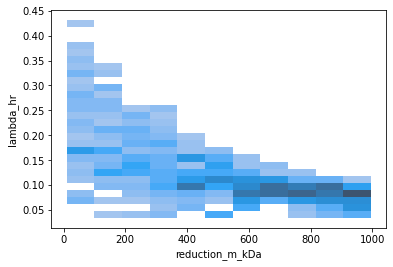

In [8]:
sns.histplot(data=res_df, y='lambda_hr', x='reduction_m_kDa', legend=False)

<AxesSubplot: xlabel='cyclic_flow_m_kDa', ylabel='lambda_hr'>

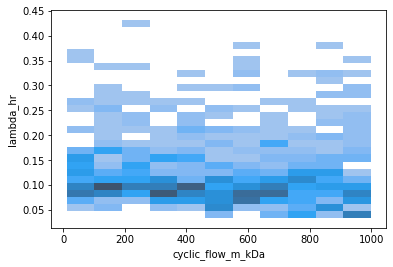

In [9]:
sns.histplot(data=res_df, y='lambda_hr', x='cyclic_flow_m_kDa', legend=False)

/opt/miniconda3/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


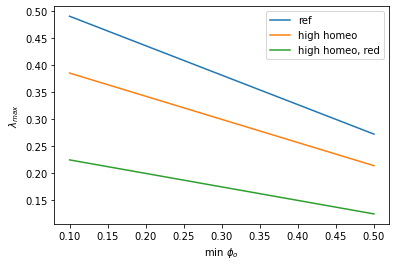

In [10]:
ref_lam = LinearMetabolicModel.FromFiles(m_fname, S_fname)

high_homeo_lam = LinearMetabolicModel.FromFiles(m_fname, S_fname)
high_homeo_lam.set_process_mass('cyclic_flow', 400) # 4x baseline

high_homeo_red_lam = LinearMetabolicModel.FromFiles(m_fname, S_fname)
high_homeo_red_lam.set_process_mass('cyclic_flow', 400) # 4x baseline
high_homeo_red_lam.set_process_mass('reduction', 400) # 4x baseline

phi_os = np.arange(0.1, 0.501, 0.1)
ref_lambdas = [ref_lam.maximize_lambda(min_phi_o=p)[0] for p in phi_os]
high_homeo_lambdas = [high_homeo_lam.maximize_lambda(min_phi_o=p)[0] for p in phi_os]
high_homeo_red_lambdas = [high_homeo_red_lam.maximize_lambda(min_phi_o=p)[0] for p in phi_os]

plt.plot(phi_os, ref_lambdas, label='ref')
plt.plot(phi_os, high_homeo_lambdas, label='high homeo')
plt.plot(phi_os, high_homeo_red_lambdas, label='high homeo, red')
plt.legend()
plt.xlabel(r'min $\phi_o$')
plt.ylabel(r'$\lambda_{max}$')
plt.show()

In [11]:
ZCBs = np.arange(-1, 1.01, 0.05)
homeo_costs = np.logspace(1, 3, 3)
ox_costs = np.logspace(1, 3, 3)
ATP_per_es = [0.25, 0.5, 0.75, 1]

# Load a model, will copy it for each run so we know we are always modifying
# same the baseline but don't need to read a file in the inner loop
lmm = LinearMetabolicModel.FromFiles(m_fname, S_fname)
results = []

for z in ZCBs:
    for homeo_cost in homeo_costs:
        for ox_cost in ox_costs:
            for atp_per_e in ATP_per_es:
                try:
                    ref_lam = lmm.copy()
                    ref_lam.set_ZCB(z)
                    ref_lam.set_process_mass('oxidation', ox_cost)
                    ref_lam.set_process_mass('cyclic_flow', homeo_cost)
                    ref_lam.set_ATP_yield('oxidation', atp_per_e)
                    max_lambda, opt_p = ref_lam.maximize_lambda(min_phi_o=0.4)

                    d = ref_lam.model_as_dict()
                    d.update(ref_lam.solution_as_dict(opt_p))
                    d['oxidation_ATP_per_e'] = atp_per_e
                    results.append(d)
                except:
                    continue
                    
res_df = pd.DataFrame(results)

In [12]:
res_df[res_df.lambda_hr > 0.1].head()

,oxidation_kcat_s,oxidation_m_kDa,reduction_kcat_s,reduction_m_kDa,anabolism_kcat_s,anabolism_m_kDa,cyclic_flow_kcat_s,cyclic_flow_m_kDa,ATP_homeostasis_kcat_s,ATP_homeostasis_m_kDa,...,oxidation_flux,reduction_phi,reduction_flux,anabolism_phi,anabolism_flux,cyclic_flow_phi,cyclic_flow_flux,ATP_homeostasis_phi,ATP_homeostasis_flux,oxidation_ATP_per_e
0,200.0,10.0,50.0,100.0,50.0,100.0,50.0,10.0,50.0,100.0,...,0.000644,0.257511,0.000129,0.257511,0.000129,0.052790,0.000264,0.000000,0.000000,0.25
1,200.0,10.0,50.0,100.0,50.0,100.0,50.0,10.0,50.0,100.0,...,0.000680,0.272109,0.000136,0.272109,0.000136,0.021769,0.000109,0.000000,0.000000,0.50
2,200.0,10.0,50.0,100.0,50.0,100.0,50.0,10.0,50.0,100.0,...,0.000583,0.233010,0.000117,0.233010,0.000117,0.000000,0.000000,0.104854,0.000052,0.75
3,200.0,10.0,50.0,100.0,50.0,100.0,50.0,10.0,50.0,100.0,...,0.000392,0.156863,0.000078,0.156863,0.000078,0.000000,0.000000,0.266667,0.000133,1.00
4,200.0,100.0,50.0,100.0,50.0,100.0,50.0,10.0,50.0,100.0,...,0.000434,0.173661,0.000087,0.173661,0.000087,0.035601,0.000178,0.000000,0.000000,0.25


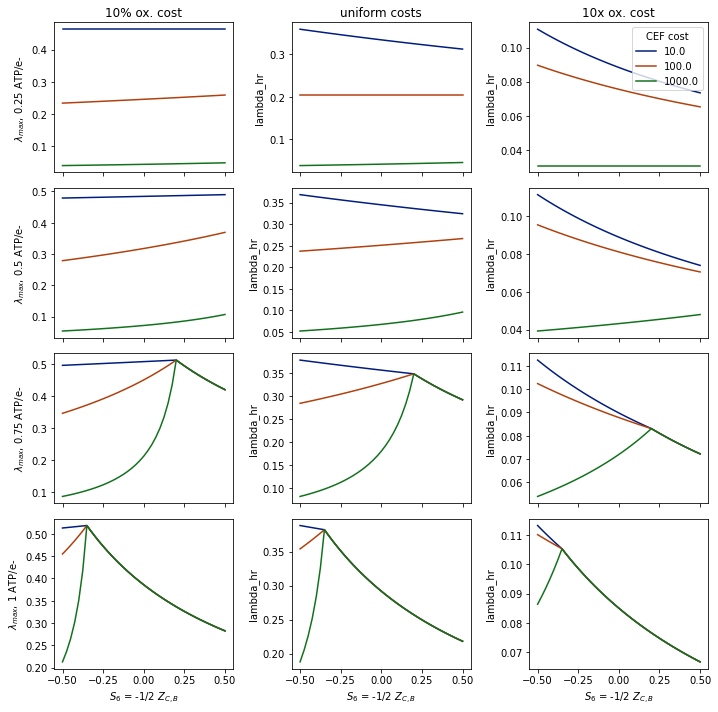

In [15]:
fig, axs = plt.subplots(figsize=(10, 10), nrows=4, ncols=3, sharex=True, sharey=False)

titles = '10% ox. cost,uniform costs,10x ox. cost'.split(',')
for i, a_per_e in enumerate(ATP_per_es):
    for j, ox_cost in enumerate(ox_costs):
        plt.sca(axs[i, j])
        mask = np.logical_and(res_df.oxidation_m_kDa == ox_cost, 
                              res_df.oxidation_ATP_per_e == a_per_e)
        sns.lineplot(data=res_df[mask], x='S6', y='lambda_hr', hue='cyclic_flow_m_kDa', palette='dark')
        plt.xlabel('$S_6$ = -1/2 $Z_{C,B}$')
        plt.legend().set_visible(False)

        if i == 0:
            plt.title(titles[j])
        
        if j == 0:
            plt.ylabel(r'$\lambda_{{max}}$, {0} ATP/e-'.format(a_per_e))

plt.sca(axs[0,2])
plt.legend(title='CEF cost').set_visible(True)

plt.tight_layout()
plt.savefig('../output/lambda_max_vs_S6_autotrophy.png', dpi=300, facecolor='white')
plt.show()

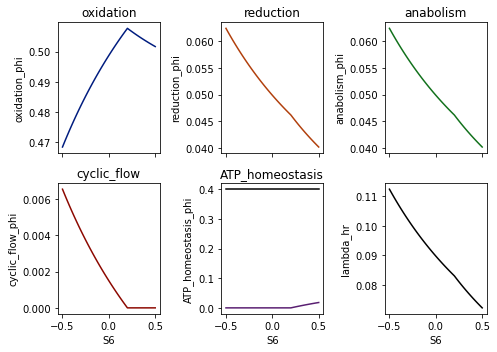

In [14]:
mask = np.logical_and(res_df.oxidation_m_kDa == 1000.0,
                      res_df.oxidation_ATP_per_e == 0.75)
mask = np.logical_and(mask, res_df.cyclic_flow_m_kDa == 10.0)

fig, axs = plt.subplots(figsize=(7, 5), nrows=2, ncols=3, sharex=True, sharey=False)
flat_axs = axs.flatten()
pal = sns.color_palette('dark', ref_lam.n_processes)
for i, p in enumerate(ref_lam.processes):
    plt.sca(flat_axs[i])
    phi_name = '{0}_phi'.format(p)
    sns.lineplot(data=res_df[mask], y=phi_name, x='S6', color=pal[i])
    plt.title(p)

plt.sca(flat_axs[-2])
sns.lineplot(data=res_df[mask], y='phi_o', x='S6', color='black')

plt.sca(flat_axs[-1])
sns.lineplot(data=res_df[mask], y='lambda_hr', x='S6', color='black')

plt.tight_layout()